In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

In [2]:
events = 11
CPU_time = []
FPGA_time = []
FPGA_BFS_time = []
FPGA_time_parallel = []


for i in range(events):
    CPU_time.append(np.loadtxt('timing_data/output_times_1/evt' + str(i) + '_ptmin_times.txt'))
    FPGA_time.append(np.loadtxt('timing_data/output_times_2/evt' + str(i) + '_ptmin_times.txt'))
    FPGA_BFS_time.append(np.loadtxt('timing_data/output_times_3/evt' + str(i) + '_ptmin_times.txt'))
    FPGA_time_parallel.append(np.loadtxt('timing_data/output_times_4/evt' + str(i) + '_ptmin_times.txt'))


In [3]:
CPU_time_mean = np.mean(CPU_time, axis = 0)
FPGA_time_mean = np.mean(FPGA_time, axis = 0)
FPGA_BFS_time_mean = np.mean(FPGA_BFS_time, axis = 0)
FPGA_time_parallel_mean = np.mean(FPGA_time_parallel, axis = 0)

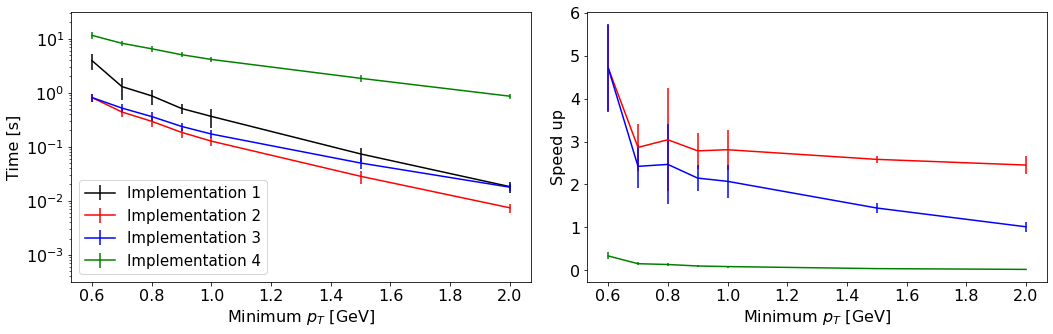

In [4]:
pt_min = [0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,5),facecolor='w')


ax1.errorbar(pt_min, CPU_time_mean/1e9, np.std(CPU_time, axis = 0)/1e9, color = 'k', label = 'Implementation 1')
ax1.errorbar(pt_min, FPGA_time_mean/1e9, np.std(FPGA_time, axis = 0)/1e9, color = 'r', label = 'Implementation 2')
ax1.errorbar(pt_min, FPGA_BFS_time_mean/1e9, np.std(FPGA_BFS_time, axis = 0)/1e9, color = 'b', label = 'Implementation 3')
ax1.errorbar(pt_min, FPGA_time_parallel_mean/1e9, np.std(FPGA_time_parallel, axis = 0)/1e9, color = 'g', label = 'Implementation 4')

ax1.set_yscale('log')
ax1.set_xlabel("Minimum $p_T$ [GeV]", fontsize = 16)
ax1.set_ylabel("Time [s]", fontsize = 16)
ax1.tick_params(axis='x', labelsize= 16)
ax1.tick_params(axis='y', labelsize= 16)
ax1.legend(fontsize = 15)
ax1.set_ylim(10**-3.5, 10**1.5)

speed_up1 = np.asarray(CPU_time) / np.asarray(FPGA_time)
speed_up2 = np.asarray(CPU_time) / np.asarray(FPGA_BFS_time)
speed_up3 = np.asarray(CPU_time) / np.asarray(FPGA_time_parallel)

ax2.errorbar(pt_min, np.mean(speed_up1, axis = 0), np.std(speed_up1, axis = 0), color = 'r')
ax2.errorbar(pt_min, np.mean(speed_up2, axis = 0), np.std(speed_up2, axis = 0), color = 'b')
ax2.errorbar(pt_min, np.mean(speed_up3, axis = 0), np.std(speed_up3, axis = 0), color = 'g')


ax2.set_xlabel("Minimum $p_T$ [GeV]", fontsize = 16)
ax2.set_ylabel("Speed up", fontsize = 16)
ax2.tick_params(axis='x', labelsize= 16)
ax2.tick_params(axis='y', labelsize= 16)


fig.tight_layout(pad = 2.0)



In [5]:
d = np.load('old_gnn_output.zip', allow_pickle=True)

In [6]:
# Plots of performance efficiency measurements for unsectorized graphs
events = 11

lhc_efficiency_all = []
perfect_clusters_all = []
double_maj_efficiency_all = []

pt_mins = ['0p6', '0p7', '0p8', '0p9', '1G', '1p5', '2']

for e in range(events):
    
    
    lhc_efficiency_all.append([])
    perfect_clusters_all.append([])
    double_maj_efficiency_all.append([])     
    file_indices = []
    ptmin = []
    

    for pt_min in pt_mins:
        for i in range(len(d.files)):
            name = d.files[i]
            if name.startswith('for_elizabeth/evt' + str(e) + '_'):
                if(name[24:].startswith(pt_min)):
                    file_indices.append(i)
                    ptmin.append(name[24:27])
                if(e == 10):
                    if(name[25:].startswith(pt_min)):
                        file_indices.append(i)
                        ptmin.append(name[24:27])
                    

    for idx in file_indices:
        true_pids = d[d.files[idx]].item().get('particle_id')
        gdbscan_labels = np.loadtxt('output_labels/' + str(d.files[idx][14:] + "_labels.txt"))

        total_particles = np.unique(true_pids)
        lhc_efficiency = 0
        perfect_clusters = 0
        double_maj_efficiency = 0
        total_found_particles = len(np.unique(gdbscan_labels))
        for label in np.unique(gdbscan_labels):
            if (label == -1) : 
                total_found_particles -= 1
                continue

            indices = np.where(gdbscan_labels == label)
            true_ids = np.asarray(true_pids, dtype = 'int')[indices[0]]
            selected_pid = np.bincount(true_ids).argmax()

            true_id_indices = np.where(true_ids == selected_pid)

            n_selected_pid = len(true_ids[true_ids==selected_pid])
            selected_pid_fraction = n_selected_pid/len(true_ids)
                
            if (selected_pid_fraction > 0.75):
                lhc_efficiency += 1

                if (n_selected_pid == len(true_ids) and n_selected_pid == len(true_id_indices[0])) :
                    perfect_clusters += 1

            if (selected_pid_fraction > 0.5 and n_selected_pid/len(true_id_indices[0]) > 0.5) :
                double_maj_efficiency += 1

        lhc_efficiency /= len(total_particles)
        perfect_clusters /= len(total_particles)
        double_maj_efficiency /= len(total_particles)

        lhc_efficiency_all[e].append(lhc_efficiency)
        perfect_clusters_all[e].append(perfect_clusters)
        double_maj_efficiency_all[e].append(double_maj_efficiency)      

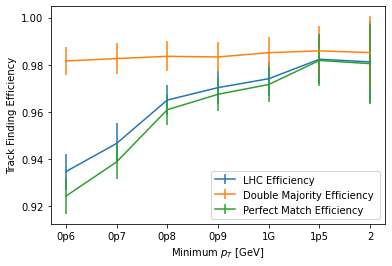

In [7]:
fig = plt.figure()

plt.errorbar(pt_mins, np.mean(lhc_efficiency_all, axis = 0), np.std(lhc_efficiency_all, axis = 0), label = 'LHC Efficiency')
plt.errorbar(pt_mins, np.mean(double_maj_efficiency_all, axis = 0), np.std(double_maj_efficiency_all, axis = 0), label = 'Double Majority Efficiency ')
plt.errorbar(pt_mins, np.mean(perfect_clusters_all, axis = 0), np.std(perfect_clusters_all, axis = 0), label = 'Perfect Match Efficiency')
plt.ylabel("Track Finding Efficiency")
plt.xlabel("Minimum $p_T$ [GeV]")

plt.legend()